In [1]:
%load_ext autoreload
%autoreload 2

#### **Libraries**

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    LabelEncoder,
)

from fasteda import fast_eda

#### **Config**

In [3]:
config = {
    "kaggle": False,
    "categorical_features": [
        "Drug",
        "Sex",
        "Ascites",
        "Hepatomegaly",
        "Edema",
        "Spiders",
        "Stage",
    ],
    "numerical_features": [
        "N_Days",
        "Age",
        "Bilirubin",
        "Cholesterol",
        "Albumin",
        "Copper",
        "Alk_Phos",
        "SGOT",
        "Tryglicerides",
        "Platelets",
        "Prothrombin",
    ],
    "target": "Status",
    "label_order": ["D", "CL", "C"],
    "random_seed": 42,
}

#### **Pre-Process Data**

In [4]:
def load_data(kaggle: bool) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    if kaggle:
        train = pd.read_csv("/kaggle/input/playground-series-s3e26/train.csv")
        test = pd.read_csv("/kaggle/input/playground-series-s3e26/test.csv")
        sub = pd.read_csv("/kaggle/input/playground-series-s3e26/sample_submission.csv")
    else:
        train = pd.read_csv("./data/train.csv")
        test = pd.read_csv("./data/test.csv")
        sub = pd.read_csv("./data/sample_submission.csv")

    return train, test, sub


def get_numerical_and_categorical_indexes(
    df: pd.DataFrame, numerical_features: list[str]
) -> tuple[list, list]:
    """ """

    n_features = df.shape[1]

    numerical_indexes = [df.columns.get_loc(column) for column in numerical_features]

    categorical_indexes = list(set(np.arange(n_features)) - set(numerical_indexes))

    return numerical_indexes, categorical_indexes


def categorical_preprocess(
    df: pd.DataFrame, features: list[str], encoder: str
) -> pd.DataFrame:
    df_ = df.copy(deep=True)

    if encoder == "ordinal":
        encoder = OrdinalEncoder(handle_unknown="error")
    elif encoder == "one-hot":
        encoder = OneHotEncoder(handle_unknown="error")

    df_[features] = encoder.fit_transform(df_[features])

    return df_


def target_preprocess(
    df: pd.DataFrame, target: str, label_order: list[str]
) -> pd.DataFrame:
    df_ = df.copy(deep=True)

    encoder = LabelEncoder()
    encoder.fit(label_order)

    df_[target] = encoder.transform(df_[target])

    return df_


def numerical_preprocess(
    x_train: np.array,
    x_test: np.array,
    numerical_indexes: list,
) -> tuple[np.array, np.array]:
    scaler = NumericalScaling(numerical_indexes)

    x_train = scaler.run(x_train, use_saved_transformer=False)
    x_test = scaler.run(x_test, use_saved_transformer=True)

    return x_train, x_test


class NumericalScaling:
    def __init__(self, numerical_indexes: list):
        self.numerical_indexes = numerical_indexes

    def run(self, x_values: np.array, use_saved_transformer: bool) -> np.array:
        if not use_saved_transformer:
            # create transformer
            self.transformer = StandardScaler()

            # fit the transformer and get scaled data
            x_values[:, self.numerical_indexes] = self.transformer.fit_transform(
                x_values[:, self.numerical_indexes]
            )

        else:
            # scale data using existing transformer
            x_values[:, self.numerical_indexes] = self.transformer.transform(
                x_values[:, self.numerical_indexes]
            )

        return x_values

In [5]:
train, test, sub = load_data(config["kaggle"])

config["numerical_indexes"], config["categorical_indexes"] = (
    get_numerical_and_categorical_indexes(
        train.drop(["id", "Status"], axis=1), config["numerical_features"]
    )
)

# order features list according to default order
config["features"] = [
    col
    for col in train.columns
    if col in config["numerical_features"] + config["categorical_features"]
]

In [6]:
# Process each DataFrame
for df_name in ["train", "test"]:
    globals()[df_name] = categorical_preprocess(
        globals()[df_name], config["categorical_features"], "ordinal"
    )

    if df_name == "train":
        globals()[df_name] = target_preprocess(
            globals()[df_name], config["target"], config["label_order"]
        )

In [7]:
# Pre-process numerical features columns
train[config["features"]], test[config["features"]] = (
    numerical_preprocess(
        train[config["features"]].values,
        test[config["features"]].values,
        config["numerical_indexes"]
    )
)

In [8]:
display(train.head())
display(train.info())
display(train.columns)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,-0.942430,0.0,0.858448,1.0,0.0,0.0,0.0,0.0,-0.077237,-0.176908,-0.572940,1.160785,-0.113334,1.336304,-0.996442,1.472341,-1.189049,2.0,2
1,1,0.497025,1.0,0.234760,0.0,0.0,0.0,0.0,0.0,-0.444429,0.068784,-0.024043,-0.275420,-0.197909,0.414968,-0.520497,1.095026,0.474024,2.0,0
2,2,1.277529,1.0,-1.262634,0.0,0.0,1.0,1.0,2.0,0.185043,-0.263923,0.004846,0.620561,-0.413812,0.097266,-1.243933,-0.757248,1.369525,3.0,2
3,3,0.498852,1.0,0.023603,0.0,0.0,0.0,0.0,0.0,-0.523113,-0.484022,-0.139601,-0.341301,-0.086017,-0.887610,-0.368194,0.043117,0.090238,2.0,0
4,4,-1.135271,1.0,-0.466107,0.0,0.0,1.0,0.0,0.0,-0.391973,-0.023351,0.293739,-0.275420,-0.333965,0.224347,-0.368194,0.374697,-0.037691,3.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7905 non-null   int64  
 1   N_Days         7905 non-null   float64
 2   Drug           7905 non-null   float64
 3   Age            7905 non-null   float64
 4   Sex            7905 non-null   float64
 5   Ascites        7905 non-null   float64
 6   Hepatomegaly   7905 non-null   float64
 7   Spiders        7905 non-null   float64
 8   Edema          7905 non-null   float64
 9   Bilirubin      7905 non-null   float64
 10  Cholesterol    7905 non-null   float64
 11  Albumin        7905 non-null   float64
 12  Copper         7905 non-null   float64
 13  Alk_Phos       7905 non-null   float64
 14  SGOT           7905 non-null   float64
 15  Tryglicerides  7905 non-null   float64
 16  Platelets      7905 non-null   float64
 17  Prothrombin    7905 non-null   float64
 18  Stage   

None

Index(['id', 'N_Days', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly',
       'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage', 'Status'],
      dtype='object')

#### How unbalanced is our train subset?

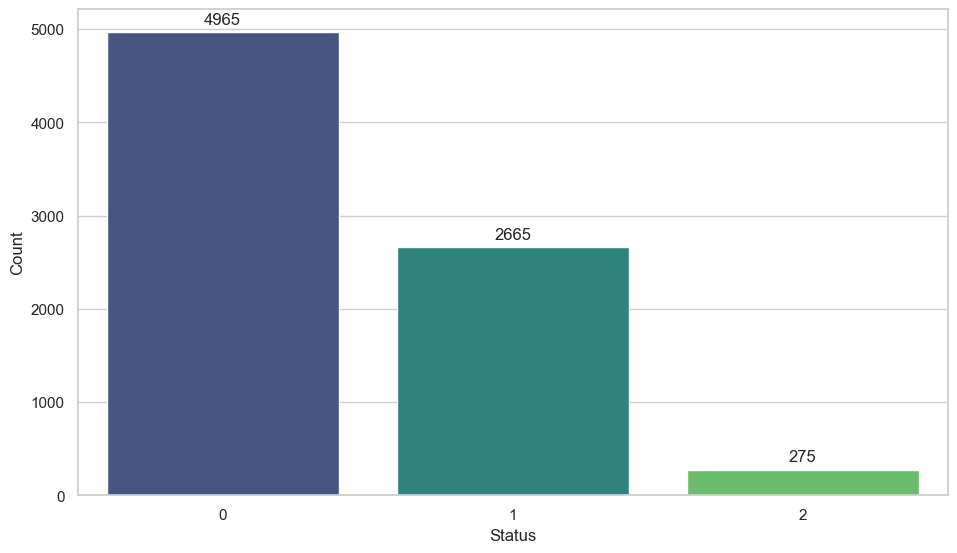

In [9]:
data = {
    "Status": np.sort(train["Status"].unique()),
    "count": pd.DataFrame(train["Status"]).value_counts().values,
}
df = pd.DataFrame(data)

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x="Status", y="count", data=df, palette="viridis")

# Adding text labels for each bar
for p in bar_plot.patches:
    bar_plot.annotate(
        format(p.get_height(), ".0f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 9),
        textcoords="offset points",
    )

plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

<Axes: xlabel='Status'>

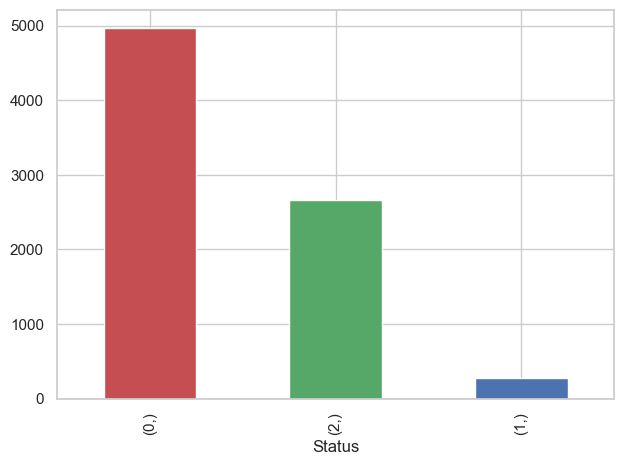

In [10]:
pd.DataFrame(train["Status"]).value_counts().plot.bar(color=["r", "g", "b"])

#### Exploratory Data Analysis

DataFrame Head:


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,-0.942430,0.0,0.858448,1.0,0.0,0.0,0.0,0.0,-0.077237,-0.176908,-0.572940,1.160785,-0.113334,1.336304,-0.996442,1.472341,-1.189049,2.0
1,0.497025,1.0,0.234760,0.0,0.0,0.0,0.0,0.0,-0.444429,0.068784,-0.024043,-0.275420,-0.197909,0.414968,-0.520497,1.095026,0.474024,2.0
2,1.277529,1.0,-1.262634,0.0,0.0,1.0,1.0,2.0,0.185043,-0.263923,0.004846,0.620561,-0.413812,0.097266,-1.243933,-0.757248,1.369525,3.0


DataFrame Tail:


,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
7902,-0.415087,0.0,2.038155,0.0,0.0,0.0,1.0,1.0,-0.155921,-0.642698,-1.035169,-0.433534,-0.464242,-0.919380,-1.015479,-0.745814,2.648812,1.0
7903,1.420103,0.0,1.246520,1.0,0.0,1.0,0.0,0.0,-0.496885,-0.524971,-2.306298,-0.683882,-0.427470,-1.173542,0.050637,-0.505705,-0.037691,3.0
7904,-0.047683,0.0,0.234760,0.0,0.0,0.0,0.0,0.0,-0.496885,-0.484022,-0.919612,-0.815644,-0.615532,-0.824070,-0.577610,0.809181,-0.421477,2.0


----------------------------------------------------------------------------------------------------
Missing values:


,0


----------------------------------------------------------------------------------------------------
Shape of DataFrame:

(7905, 18)

----------------------------------------------------------------------------------------------------
DataFrame Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7905 entries, 0 to 7904
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         7905 non-null   float64
 1   Drug           7905 non-null   float64
 2   Age            7905 non-null   float64
 3   Sex            7905 non-null   float64
 4   Ascites        7905 non-null   float64
 5   Hepatomegaly   7905 non-null   float64
 6   Spiders        7905 non-null   float64
 7   Edema          7905 non-null   float64
 8   Bilirubin      7905 non-null   float64
 9   Cholesterol    7905 non-null   float64
 10  Albumin        7905 non-null   float64
 11  Copper         7905 non-null   float64
 12  Alk_Phos       7905 

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/fasteda/__init__.py:86: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  full_info.iloc[:,:-2] = full_info.iloc[:,:-2].applymap(lambda x: format(x, '.3f') \
/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/fasteda/__init__.py:86: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'N_Days           7905
Drug             7905
Age              7905
Sex              7905
Ascites          7905
Hepatomegaly     7905
Spiders          7905
Edema            7905
Bilirubin        7905
Cholesterol      7905
Albumin          7905
Copper           7905
Alk_Phos         7905
SGOT             7905
Tryglicerides    7905
Platelets        7905
Prothrombin      7905
Stage            7905
Name: count, dtype: object' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  full_info.iloc[:,:-2] = full_info

,count,mean,median,std,min,25%,50%,75%,max,skewness,kurtosis
N_Days,7905,-0,-0.182,1,-1.818,-0.731,-0.182,0.602,2.527,0.448575,-0.494464
Drug,7905,0.507,1,0.5,0,0,1,1,1,-0.029099,-1.999153
Age,7905,-0,0.092,1,-2.385,-0.761,0.092,0.628,2.793,0.084075,-0.497827
Sex,7905,0.072,0,0.258,0,0,0,0,1,3.312153,8.970357
Ascites,7905,0.048,0,0.214,0,0,0,0,1,4.225296,15.853130
Hepatomegaly,7905,0.511,1,0.5,0,0,1,1,1,-0.045299,-1.997948
Spiders,7905,0.245,0,0.43,0,0,0,0,1,1.183998,-0.598148
Edema,7905,0.138,0,0.454,0,0,0,0,2,3.333598,10.025055
Bilirubin,7905,-0,-0.392,1,-0.602,-0.497,-0.392,0.106,6.663,3.339062,12.899902
Cholesterol,7905,0,-0.269,1,-1.18,-0.525,-0.269,0.202,7.291,3.678959,18.150082


----------------------------------------------------------------------------------------------------
DataFrame Correlation:



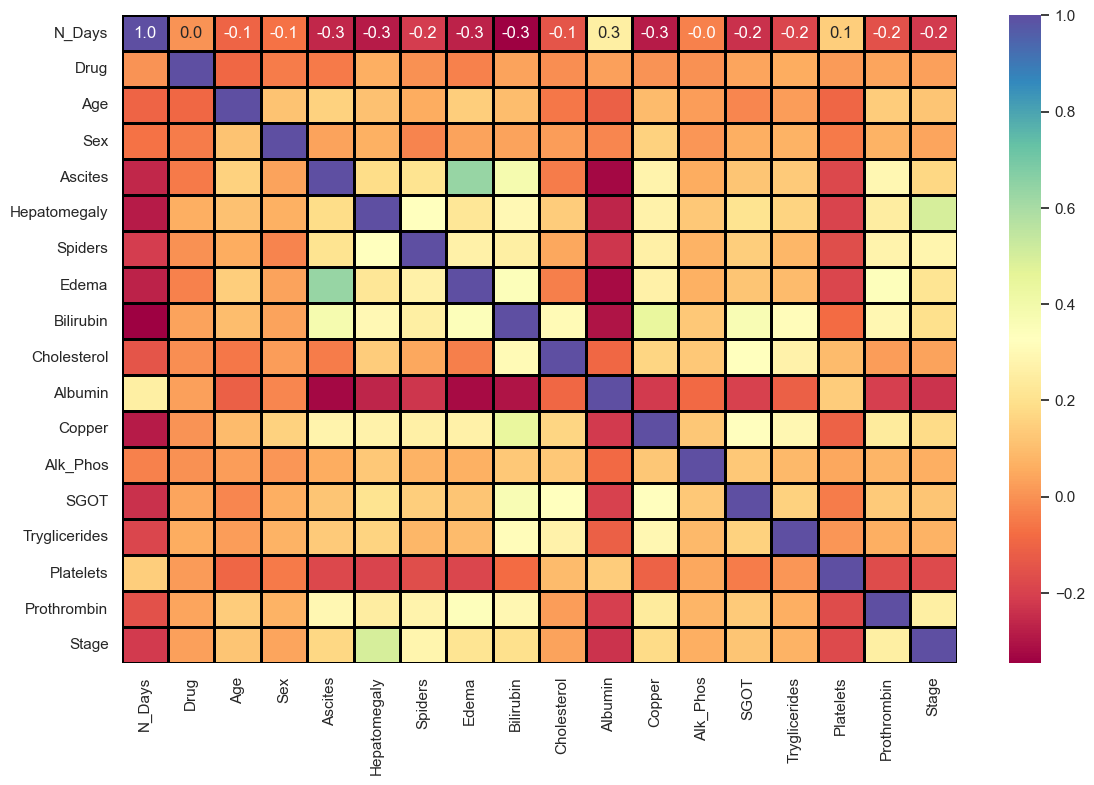

----------------------------------------------------------------------------------------------------
Histogram(s) & Boxplot(s):



/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


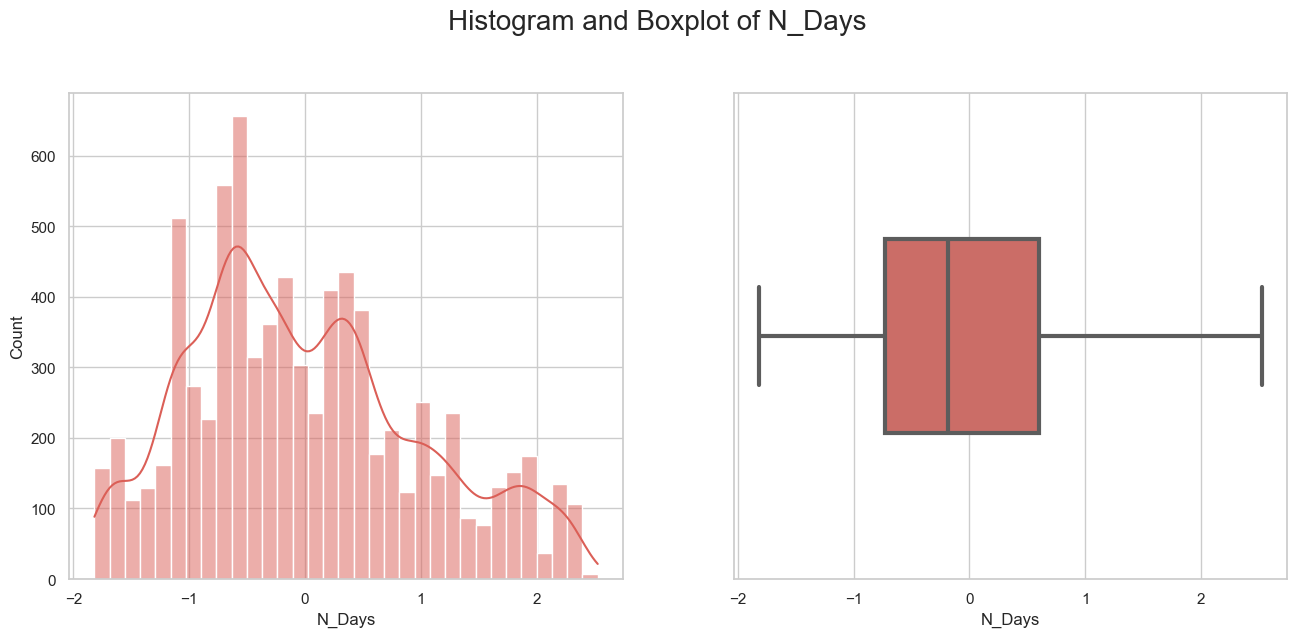

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


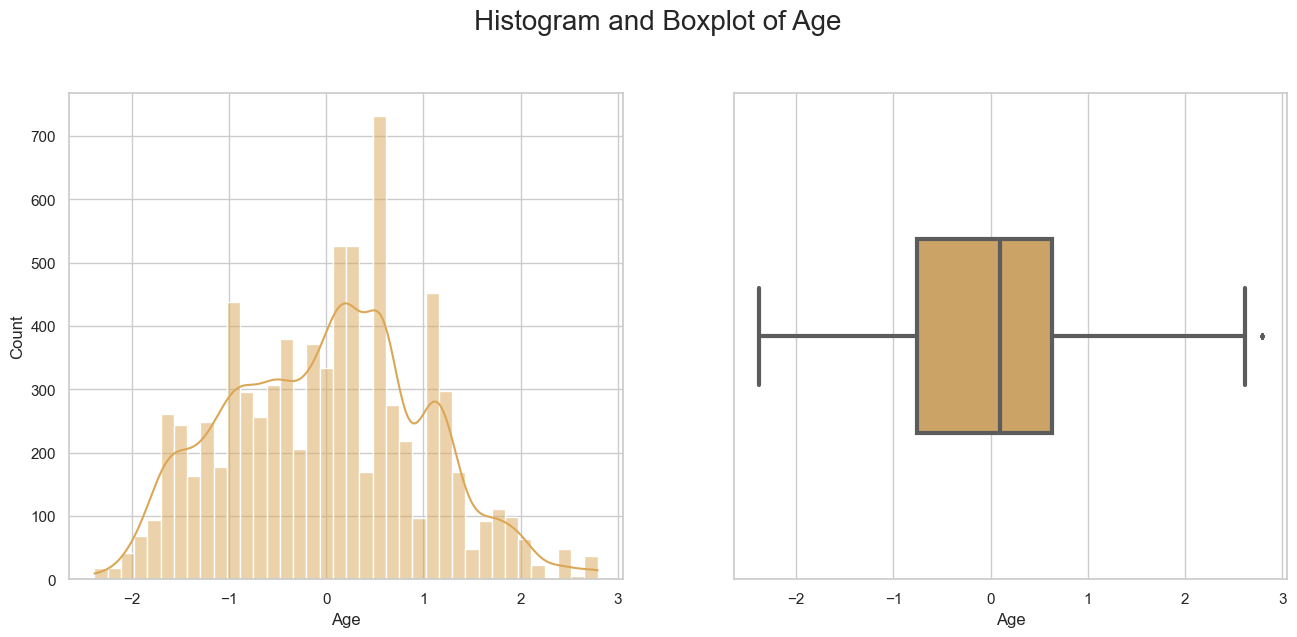

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


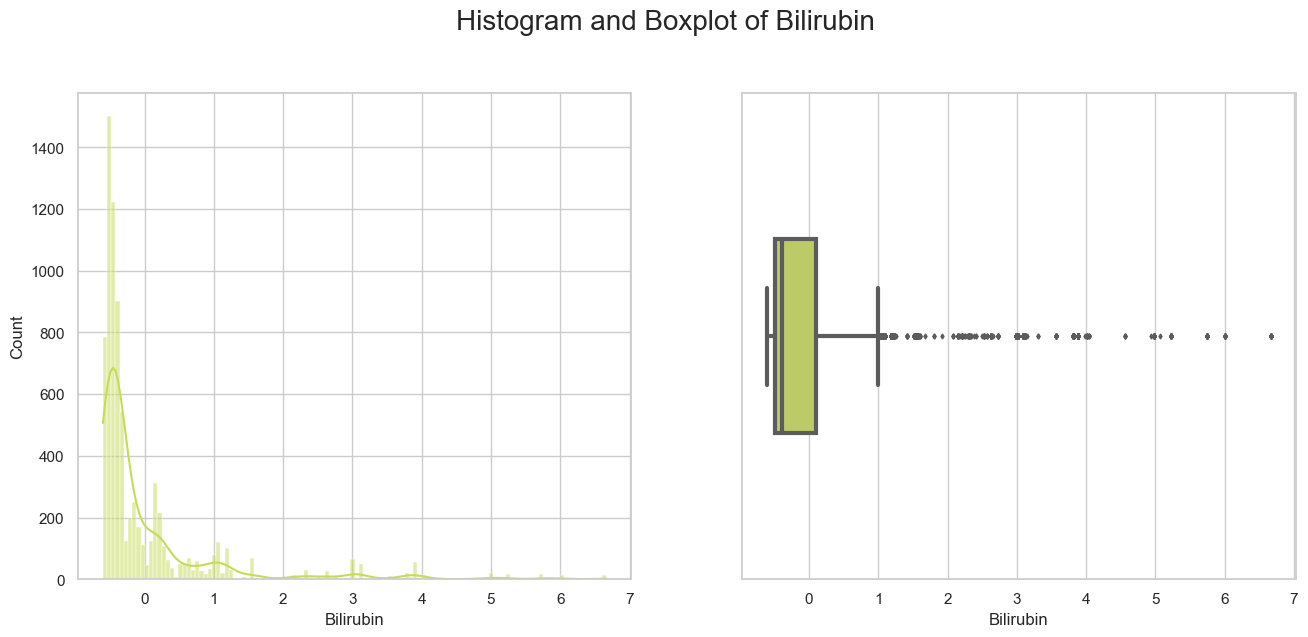

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


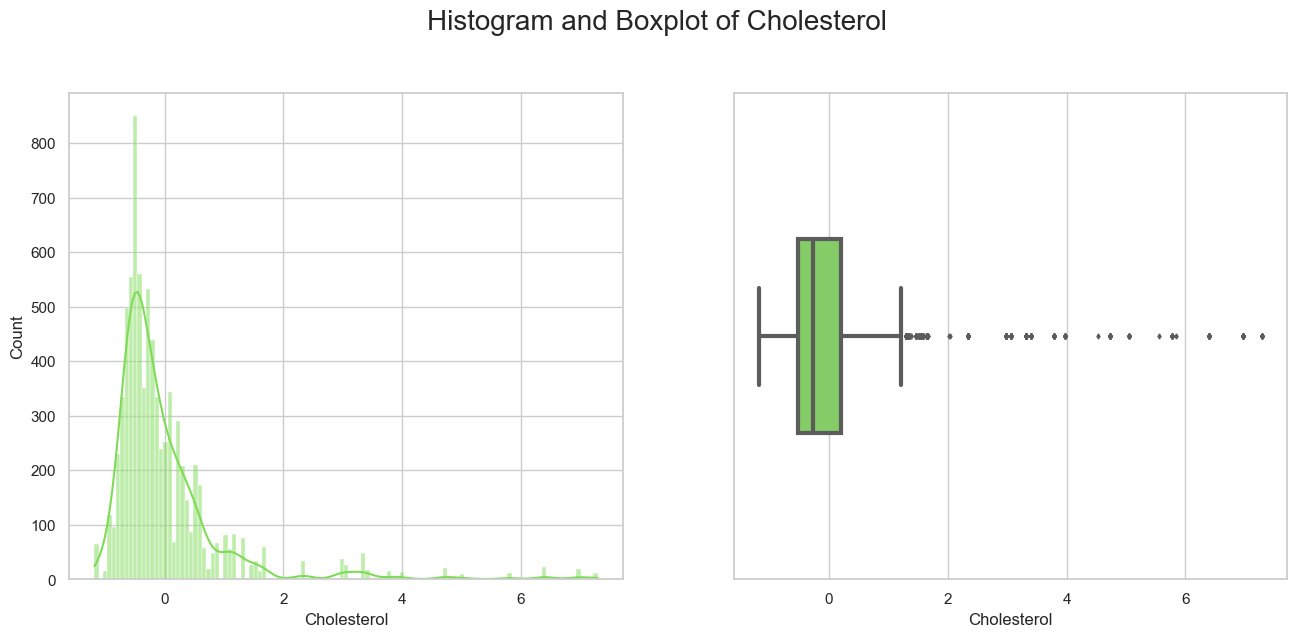

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


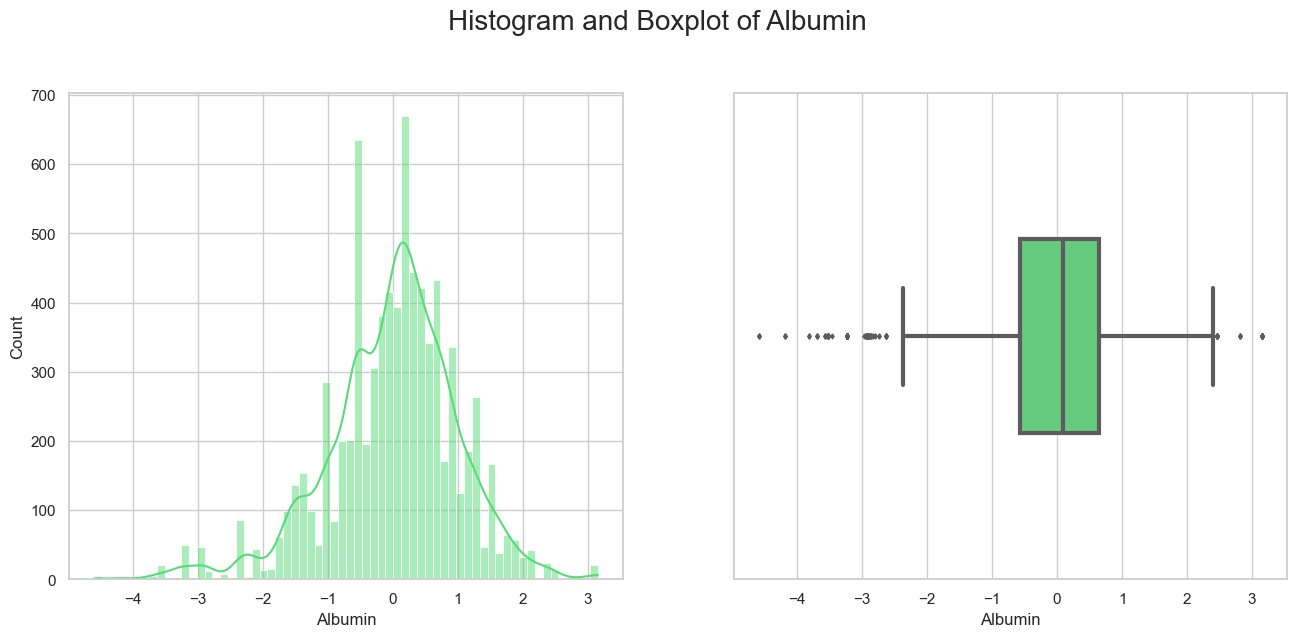

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


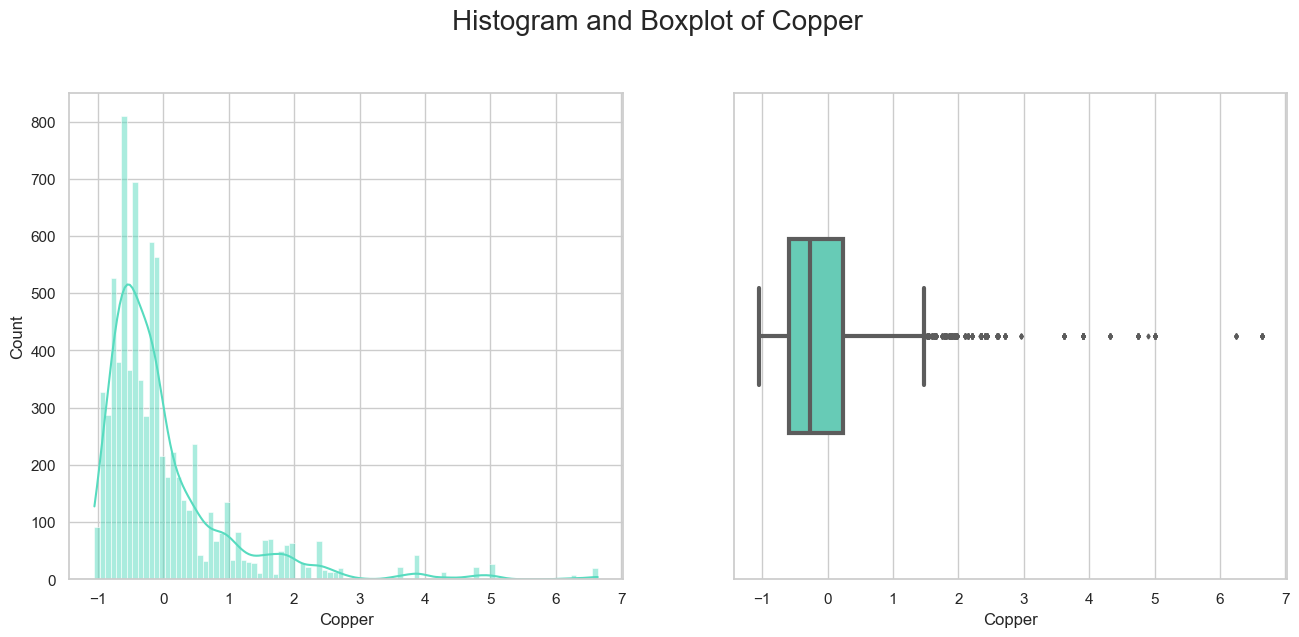

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


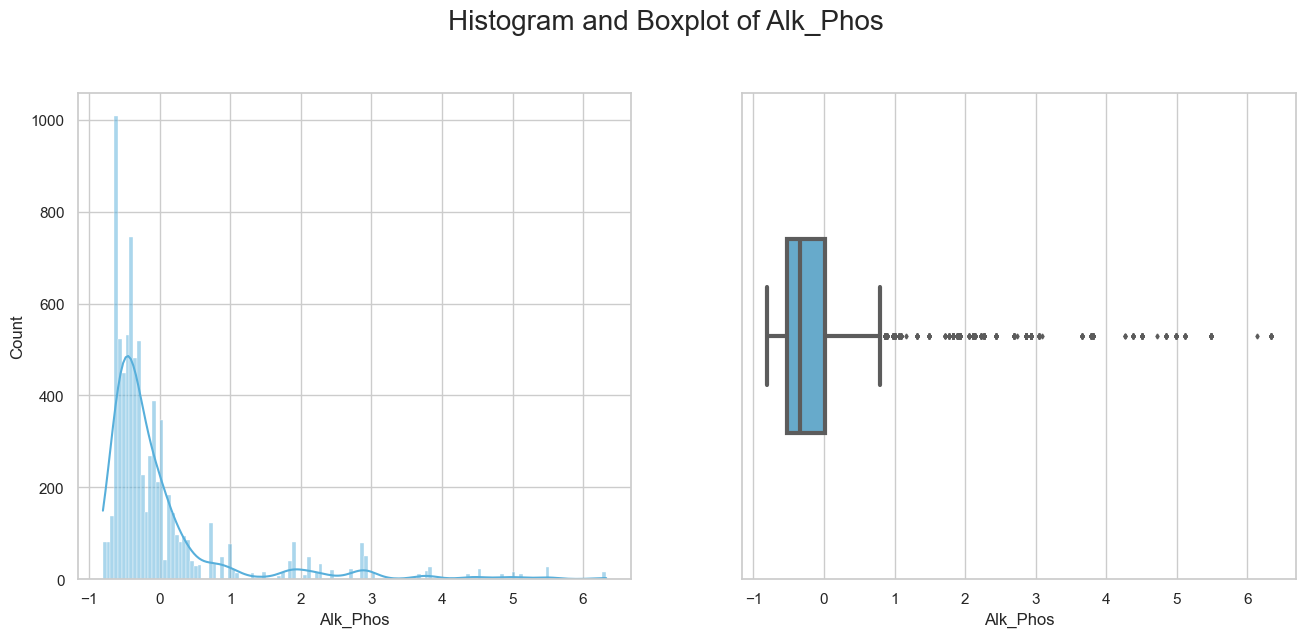

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


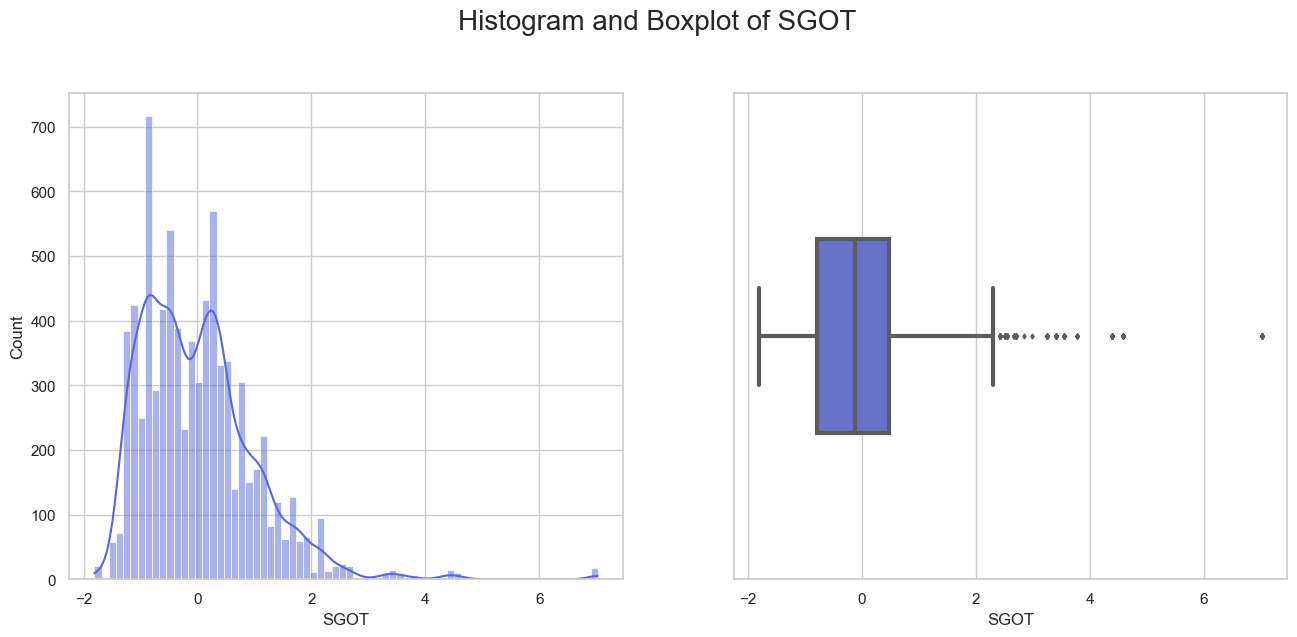

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


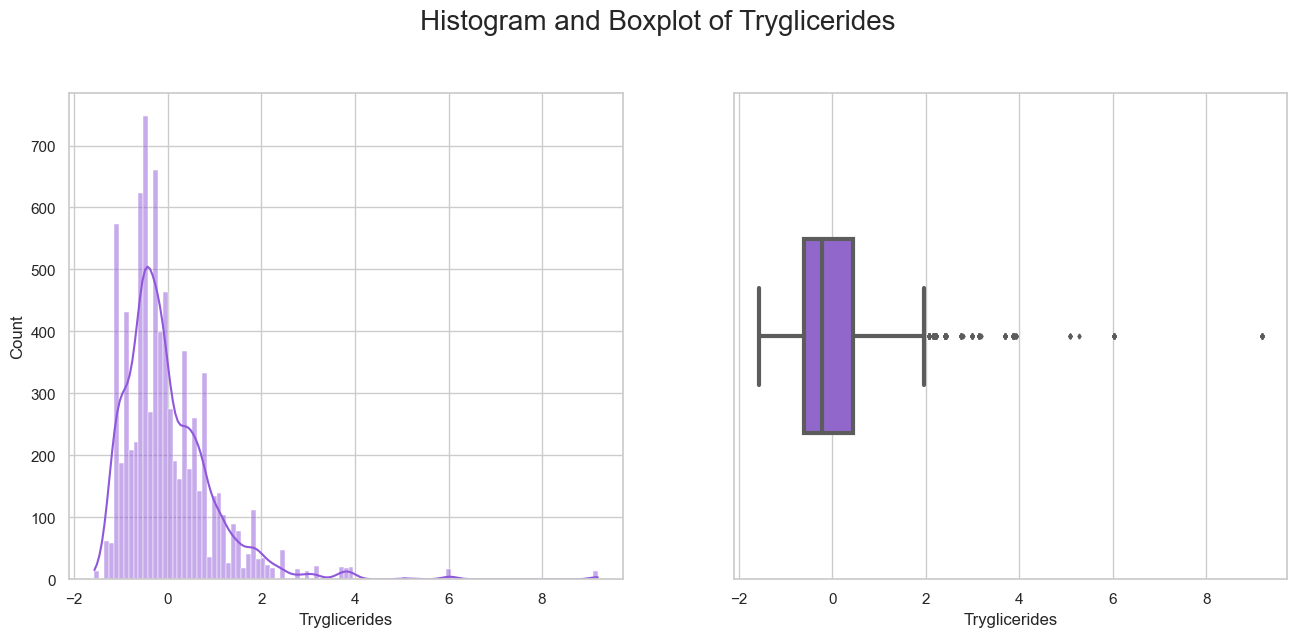

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


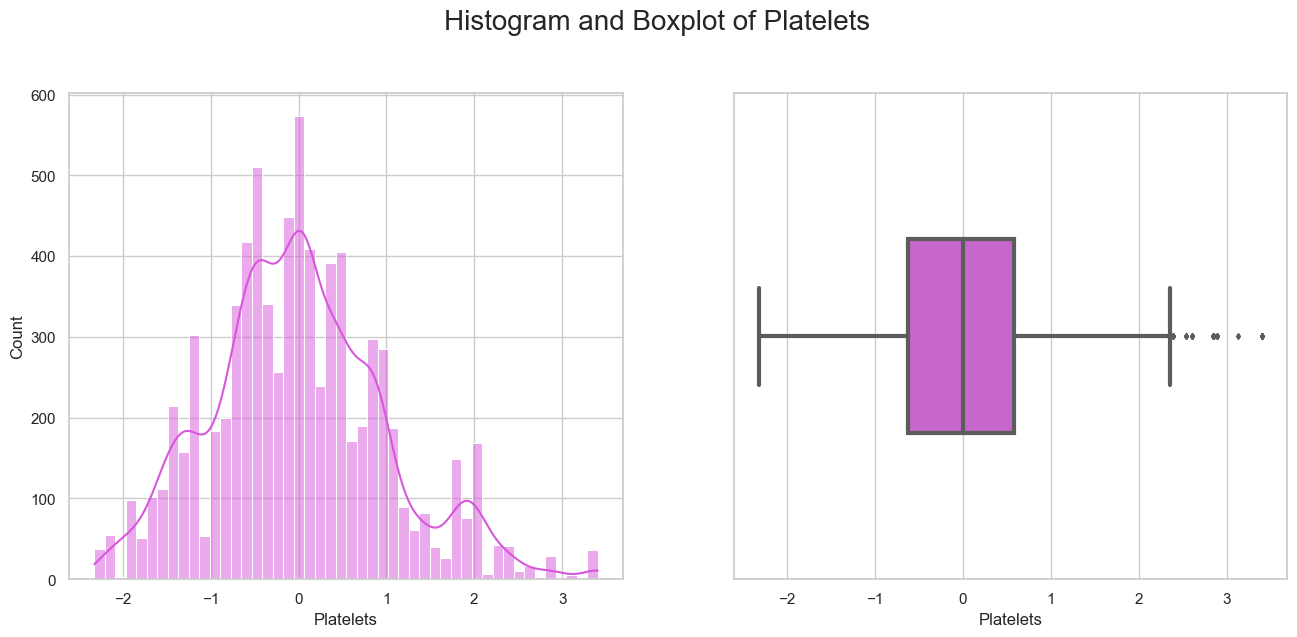

/opt/miniconda3/envs/py311env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


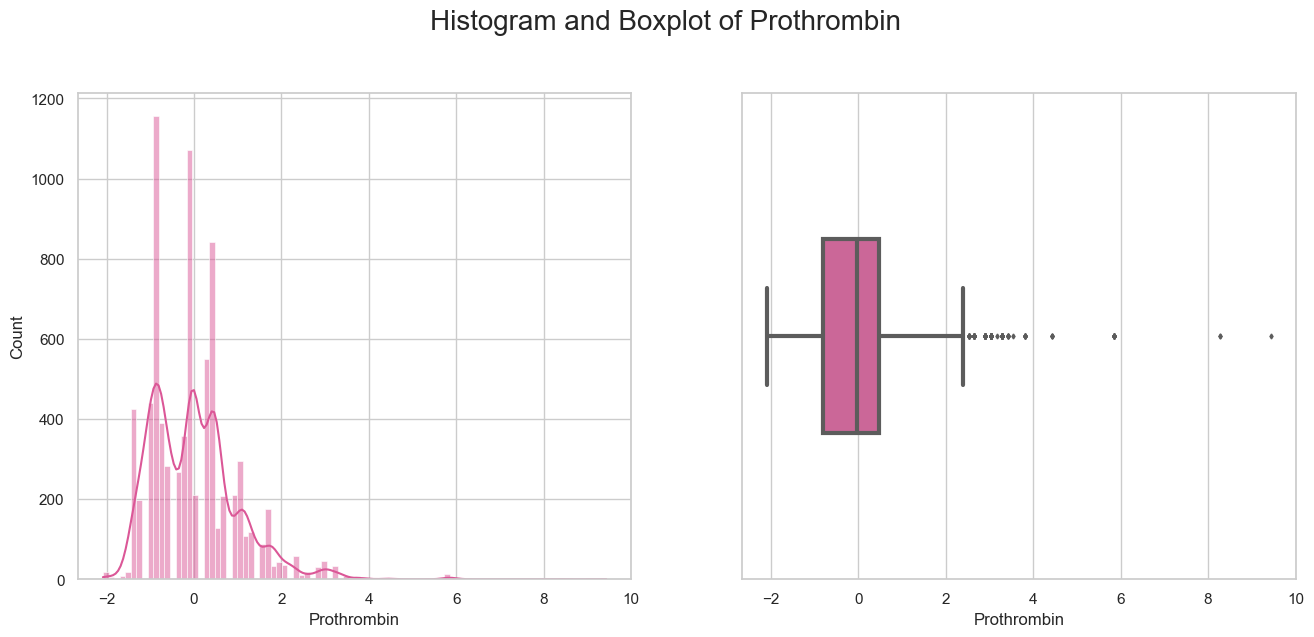

----------------------------------------------------------------------------------------------------
Countplot(s):



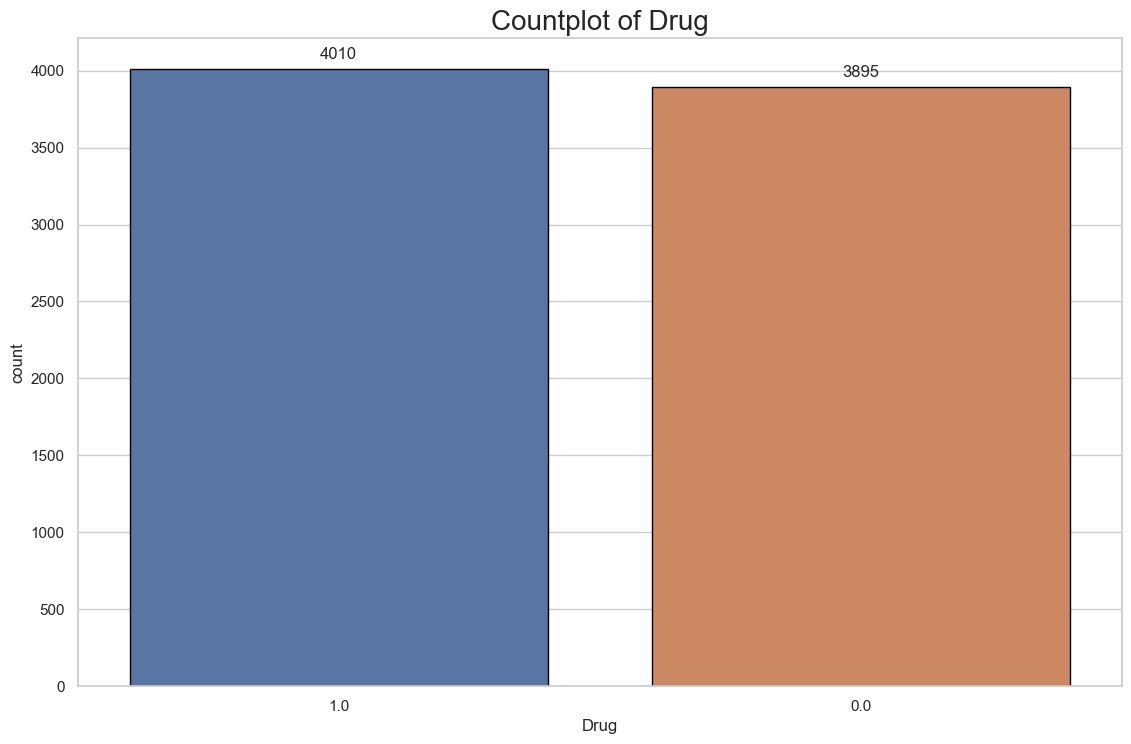

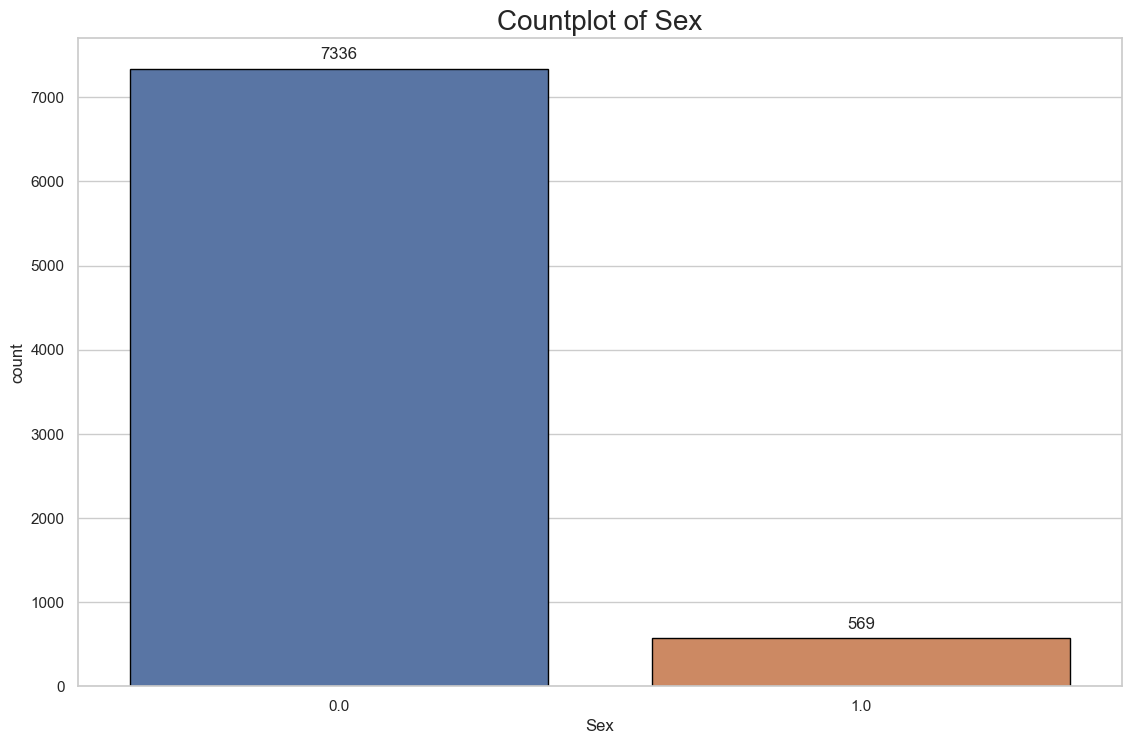

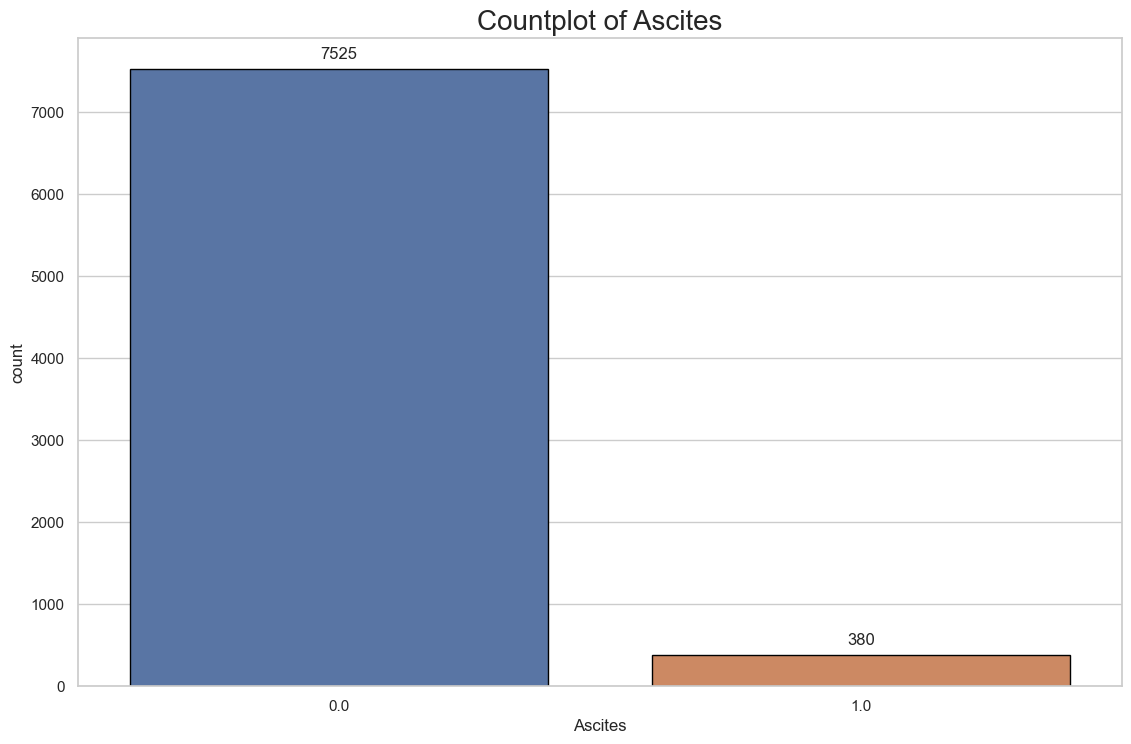

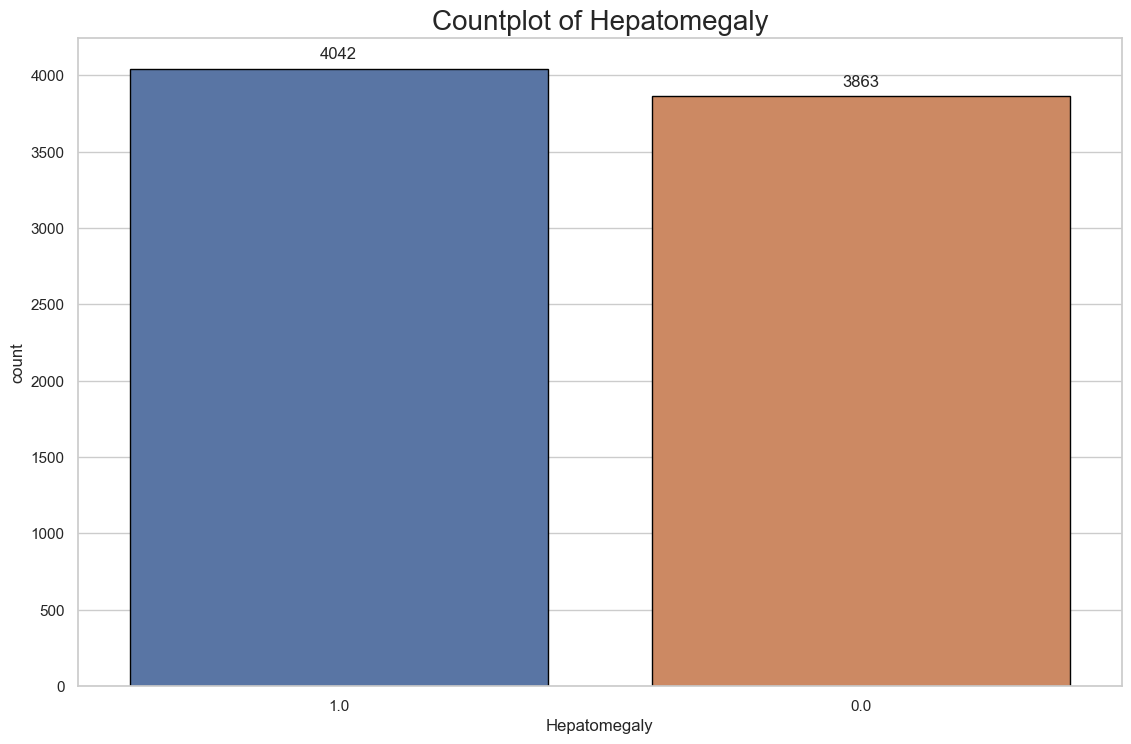

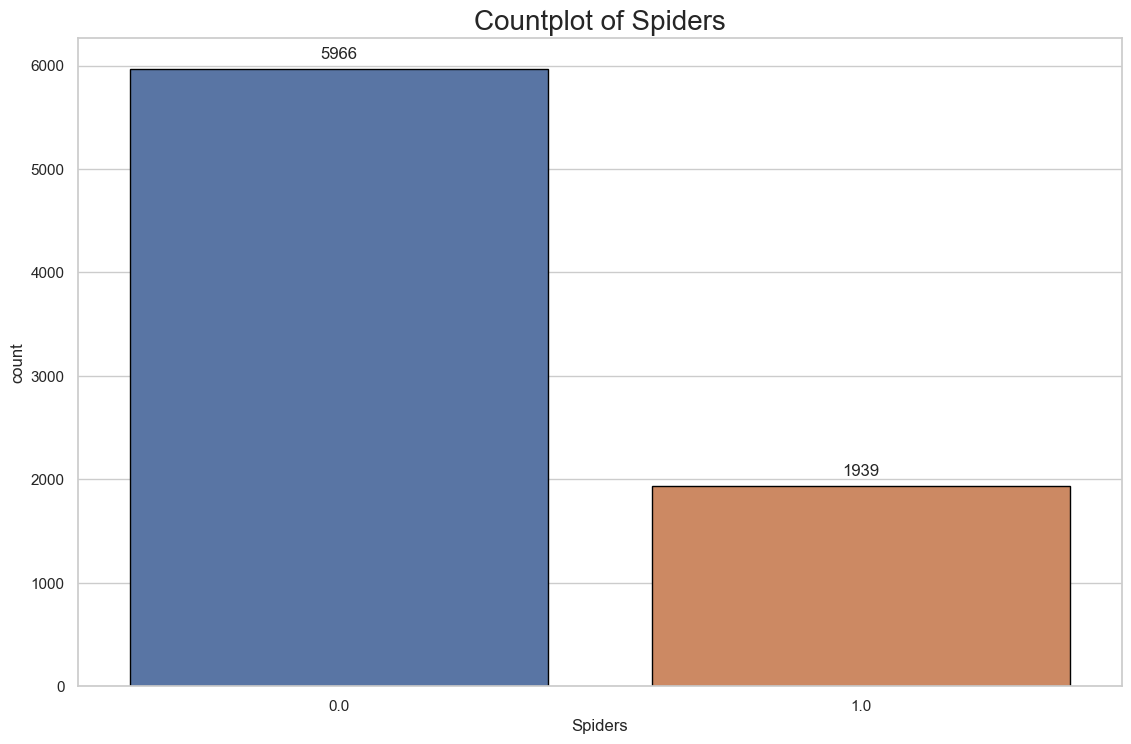

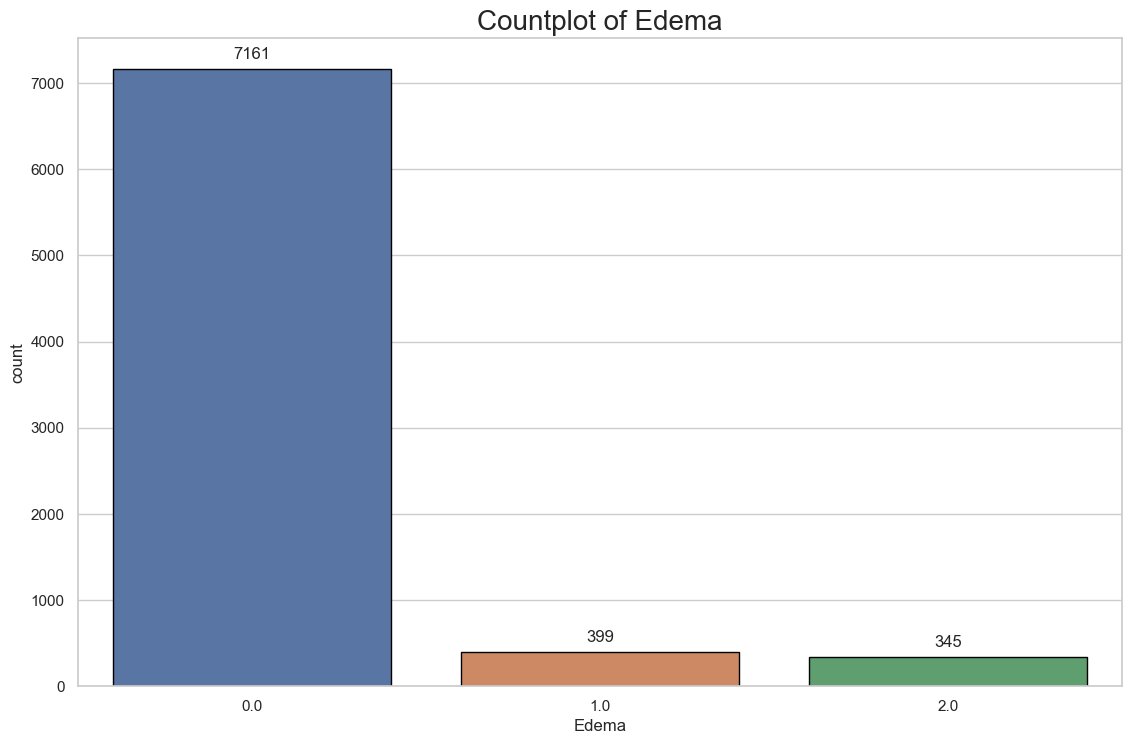

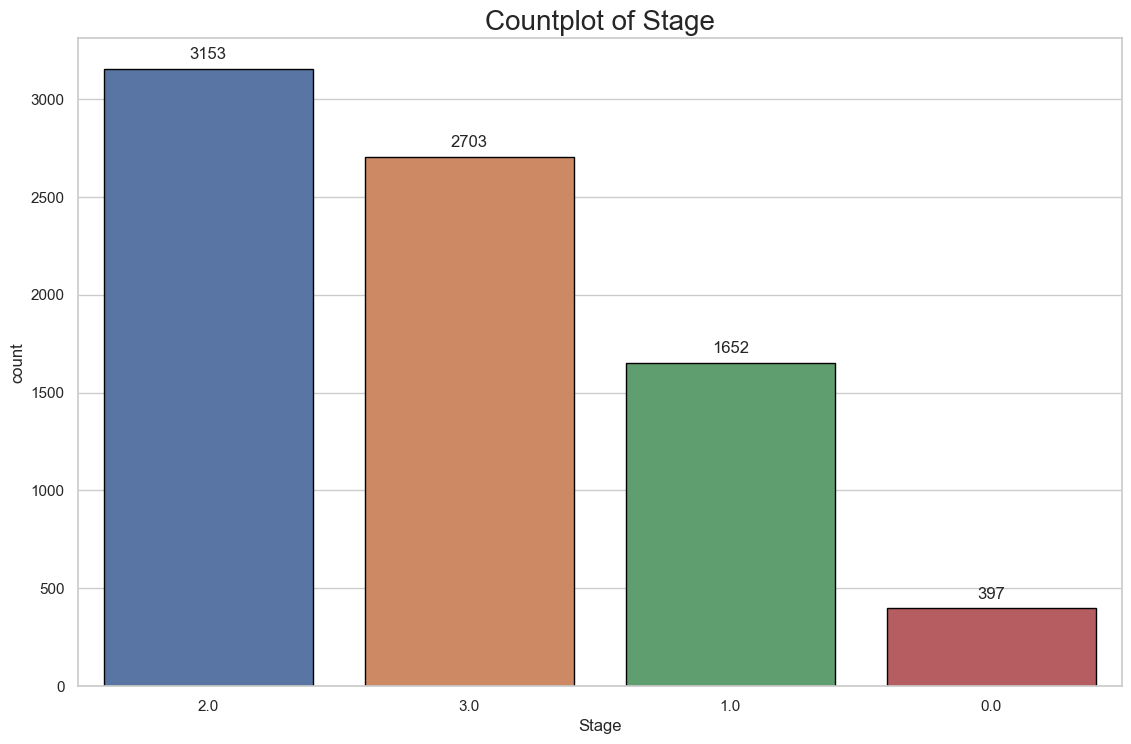

In [11]:
# X train subset
fast_eda(train[config["features"]])